In [3]:
import numpy as np
from nltk.tokenize import RegexpTokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers.core import Dense, Activation
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import heapq

In [4]:
text = open('1661-0.txt',encoding="utf8").read().lower()
print('corpus length:', len(text))

corpus length: 581888


In [5]:
tokenizer = RegexpTokenizer(r'\w+')
words = tokenizer.tokenize(text)

In [6]:
unique_words = np.unique(words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))

In [7]:
WORD_LENGTH = 5
prev_words = []
next_words = []
for i in range(len(words) - WORD_LENGTH):
    prev_words.append(words[i:i + WORD_LENGTH])
    next_words.append(words[i + WORD_LENGTH])
print(prev_words[0])
print(next_words[0])

['project', 'gutenberg', 's', 'the', 'adventures']
of


In [8]:
X = np.zeros((len(prev_words), WORD_LENGTH, len(unique_words)), dtype=bool)
Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)
for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
    Y[i, unique_word_index[next_words[i]]] = 1

In [9]:
model = Sequential()
model.add(LSTM(128, input_shape=(WORD_LENGTH, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))


In [98]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               4264960   
                                                                 
 dense (Dense)               (None, 8201)              1057929   
                                                                 
 activation (Activation)     (None, 8201)              0         
                                                                 
Total params: 5,322,889
Trainable params: 5,322,889
Non-trainable params: 0
_________________________________________________________________


In [10]:
# optimizer = RMSprop(lr=0.01)
# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# history = model.fit(X, Y, validation_split=0.2, batch_size=128, epochs=20, shuffle=True).history

In [13]:
# model.save('keras_next_word_model.h5')
# pickle.dump(history, open("history.p", "wb"))
model = load_model('keras_next_word_model.h5')
history = pickle.load(open("history.p", "rb"))

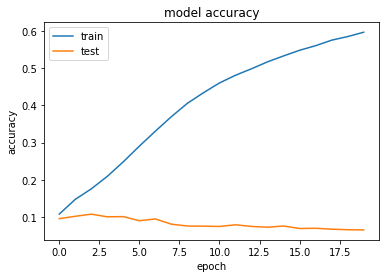

In [14]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

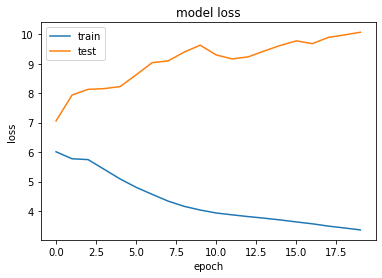

In [15]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [83]:
def prepare_input(text):
    x = np.zeros((1, WORD_LENGTH, len(unique_words)))
    # x = np.zeros((1, len(text.split()), len(unique_words)))
    for t, word in enumerate(text.split()):
        x[0, t, unique_word_index[word]] = 1
    return x

prepare_input("It is not a lack".lower())

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [84]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [85]:
# def predict_completion(text):
#     original_text = text
#     generated = text
#     completion = ''
#     while True:
#         x = prepare_input(text)
#         preds = model.predict(x, verbose=0)[0]
#         next_index = sample(preds, top_n=1)[0]
#         next_char = unique_word_index[next_index]
#         text = text[1:] + next_char
#         completion += next_char
        
#         if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
#             return completion

In [86]:
def predict_completions(text, n=3):
    if text == "":
        return("0")
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [unique_words[idx] for idx in next_indices]

In [96]:
quotes = [
    "They were admirable things for the observer—excellent for drawing the veil from men’s motives and actions.",
    "I could not help laughing at the ease with which he explained his process of deduction.",
    "A slow and heavy step, which had been heard upon the stairs and in the passage, paused immediately outside the door."
]

In [97]:
for q in quotes:
    seq = " ".join(tokenizer.tokenize(q.lower())[0:5])
    print(seq)
    print(predict_completions(seq, 5))
    print()

they were admirable things for
['the', 'i', 'me', 'a', 'for']

i could not help laughing
['at', 'in', 'a', 'its', 'the']

a slow and heavy step
['which', 'in', 'the', 'into', 'his']

